In [362]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import cv2
import xraylib

from holotomocupy.holo import G
from holotomocupy.magnification import M
from holotomocupy.shift import S
from holotomocupy.utils import *

%matplotlib inline

np.random.seed(10)

In [363]:
n = 2048  # object size in each dimension

center = n/2 # rotation axis
npos = 1  # number of code positions
detector_pixelsize = 1e-6
energy = 30  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 50+1.2  # [m]
z1 = 50
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8*0
# sample size after demagnification
ne = n+2*pad
show = True

20.276034163602993


<Axes: >

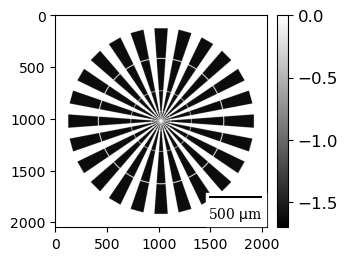

In [364]:
img = np.zeros((ne, ne, 3), np.uint8)
triangle = np.array([(ne//16, ne//2-ne//32), (ne//16, ne//2+ne//32), (ne//2-ne//128, ne//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((ne, ne, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-ne//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+ne//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2))
x = x/ne*2
y = y/ne*2
# add holes in triangles
circ = (x**2+y**2>0.355)+(x**2+y**2<0.345)
circ *= (x**2+y**2>0.083)+(x**2+y**2<0.08)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-ne//2,ne//2)/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-0*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 3e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')
print(delta/beta)
vvmin=-1.7
vvmax=0
mshowfull(np.angle(psi[0]))

In [365]:
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as ssim
def mshow(a,**args):
    aa=a.copy()
    aa[0,0]=vvmin
    aa[0,1]=vvmax
    plt.imshow(aa,**args)

def mshowfull(u):
    fig, ax = plt.subplots(figsize=(3,3))
    shape = u.shape
    im = ax.imshow(u,cmap='gray',vmax=vvmax,vmin=vvmin)
    scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
            "family": "serif",
        },  # For more information, see the cell below
        location="lower right")
    ax.add_artist(scalebar)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    
    # ax.set_title(f'Propagation distance {z2[0]} m ')
    # ax.tick_params(axis='both', which='major', labelsize=11)
    
    
    # uu = u
    # ins_ax = ax.inset_axes([0.5, 0.5, .5, .5])  # [x, y, width, height] w.r.t. ax
    # uu = uu[270:270+200,270:270+200]
    # uu[:,:1] = vvmax
    # uu[-1:,:] = vvmax
    # uu[0,0] = vvmin
    
    # ins_ax.imshow(uu,cmap='gray',vmax=vvmax,vmin=vvmin)
    # ins_ax.axis('off')
    # ax.set_colorbar()    
    return ax

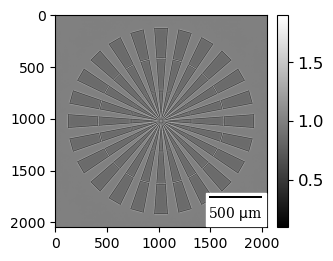

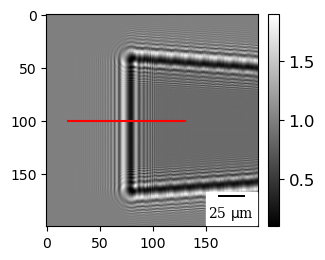

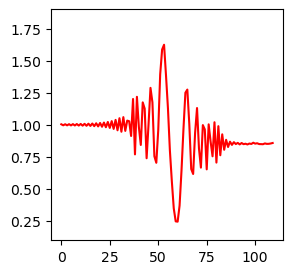

In [366]:
def fwd_holo(psi):
    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

# Apply the forward transform
psi = cp.array(psi)
fpsi = fwd_holo(psi)
data = cp.abs(fpsi)**2
# mshow(data[0,0],show,vmin=0.55,vmax=1.25)
# mshow(data[0,0,270:270+200,270:270+200],show,vmax=1.25)#,vmin=0.95,vmax=1.2)
vvmin = 0.1
vvmax=1.9
mshowfull(data[0,0].get())
plt.savefig(f'figs/data{z2-z1}.png',dpi=300,bbox_inches='tight')
ax = mshowfull(data[0,0,1020-100:1020+100,50:250].get())
ax.plot([20,130],[100,100],'r')
# plt.show()
plt.savefig(f'figs/datas{z2-z1}.png',dpi=300,bbox_inches='tight')
fig, ax = plt.subplots(figsize=(3,3))
plt.plot(data[0,0,1020-100:1020+100,50:250][100,20:130].get(),'r')
plt.ylim([vvmin,vvmax])
# plt.show()
plt.savefig(f'figs/datap{z2-z1}.png',dpi=300,bbox_inches='tight')

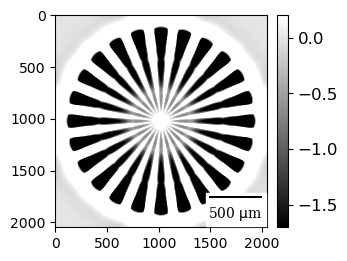

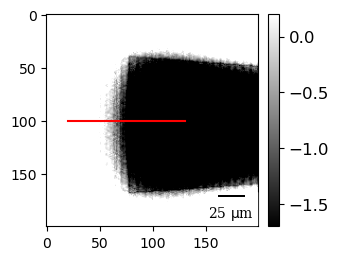

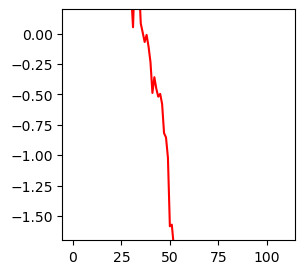

In [372]:
from holotomocupy.recon_methods import CTFPurePhase
a = CTFPurePhase(data[0:1,0:1],distances[0:1], wavelength, voxelsize,  1e-2)
vvmin=-1.7
vvmax=0.2
mshowfull(a[0].get())
plt.savefig(f'figs/rec{z2-z1}.png',dpi=300,bbox_inches='tight')
ax = mshowfull(a[0,1020-100:1020+100,50:250].get())
ax.plot([20,130],[100,100],'r')
# plt.show()
plt.savefig(f'figs/recs{z2-z1}.png',dpi=300,bbox_inches='tight')
fig, ax = plt.subplots(figsize=(3,3))
plt.plot(a[0,1020-100:1020+100,50:250][100,20:130].get(),'r')
plt.ylim([vvmin,vvmax])
# plt.show()
plt.savefig(f'figs/recp{z2-z1}.png',dpi=300,bbox_inches='tight')